**<span style="color:#01bef4">OBJETIVO</span>** ➡️ determinar si existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados, y si es así, cuál es la magnitud de esa relación.

* **<span style="color:#FF0000">Hipótesis Nula (H0)</span>** = "No existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa. Se sospecha que los empleados con niveles de satisfacción más bajos tienen una mayor probabilidad de dejar la empresa".

* **<span style="color:#00bf63">Hipótesis Alternativa (H1)</span>** = "Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa. Se sospecha que los empleados con niveles de satisfacción más bajos tienen una mayor probabilidad de dejar la empresa".

In [36]:
# Importación de librerías:

# Tratamiento de datos:
import pandas as pd
import numpy as np

import re

# -----------------------------------------------------------------------
# Imputación de nulos usando métodos avanzados estadísticos:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# -----------------------------------------------------------------------
# Visualización:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# -----------------------------------------------------------------------
# Evaluación de la linealidad de las relaciones entre variables y su distribución:
import scipy.stats as stats
from scipy.stats import levene, skew, chi2_contingency, ttest_ind
from scipy.stats import shapiro, poisson, chisquare, expon, kstest
import statsmodels.api as sm
from statsmodels.formula.api import logit

# -----------------------------------------------------------------------
# Configuración para poder visualizar todas las columnas de los DataFrames:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# -----------------------------------------------------------------------
# Gestión de los warnings:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_abc = pd.read_csv("HR_DATA_CLEAN.csv")
df_abc.head()

,age,attrition,business_travel,daily_rate,department,distance_from_home,education,education_field,employee_number,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,anual_income,monthly_rate,num_companies_worked,over18,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,standard_hours,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager,year_birth,monthly_income,number_children,remote_work
0,51,No,Unknown,684.0,Unknown,6.0,3,Unknown,162,1,Male,51.0,3,2,Research Director,3,Unknown,19537.00,6462.0,7,Yes,No,13.0,3,3,NaN,0.0,0,5,3,20,0,15,15,1972,1628.08,NaN,Yes
1,52,No,Unknown,699.0,Unknown,1.0,4,Life Sciences,259,3,Male,65.0,2,2,Manager,3,Unknown,19999.00,5678.0,0,Yes,Unknown,14.0,3,1,NaN,1.0,34,5,3,33,0,11,9,1971,1666.58,NaN,Yes
2,42,No,Travel Rarely,532.0,Research & Development,4.0,2,Technical Degree,319,3,Male,58.0,3,2,Manager,4,Married,19232.00,4933.0,1,Yes,No,11.0,3,4,NaN,0.0,22,3,0,22,0,11,15,1981,1602.67,NaN,Yes
3,47,No,Travel Rarely,359.0,Unknown,2.0,4,Medical,0,1,Female,82.0,3,4,Research Director,3,Married,17169.00,26703.0,3,Yes,Unknown,19.0,3,2,NaN,2.0,0,2,0,20,0,5,6,1976,1430.75,NaN,No
4,46,No,Unknown,1319.0,Unknown,3.0,3,Technical Degree,0,1,Female,45.0,4,4,Sales Executive,1,Divorced,6982.03,7739.0,2,Yes,No,12.0,3,4,NaN,1.0,0,5,3,19,0,2,8,1977,581.84,NaN,No


Creamos una columna nueva en base al nivel de satisfacción en el trabajo incluyendo el grupo de control y el grupo test.

* **<span style="color:#01bef4">Grupo A (Control):</span>**\
**Empleados con un nivel de satisfacción en el trabajo igual o superior a 3 en una escala de 1 a 5.**

* **<span style="color:#01bef4">Grupo B (Variante):</span>**\
**Empleados con un nivel de satisfacción en el trabajo inferior a 3 en la misma escala.**

**1. Dividimos a los empleados en los grupos A y B según los criterios establecidos.**

In [4]:
# Creamos un nuevo DataFrame que únicamente incluya las columnas cuya relacióne stamos estudiando.
df_abtesting = df_abc[["attrition", "job_satisfaction"]]
df_abtesting

,attrition,job_satisfaction
0,No,3
1,No,3
2,No,4
3,No,3
4,No,1
...,...,...
1505,No,2
1506,Yes,3
1507,No,4
1508,No,3


In [5]:
# Filtramos los datos en dos grupos 
def categorizacion(numero):
    if numero >= 3:
        return "group A"
    else:
        return "group B"
    
df_abtesting["group"]= df_abtesting["job_satisfaction"].apply(categorizacion)

In [6]:
df_abtesting.sample(5)

,attrition,job_satisfaction,group
11,No,2,group B
1075,No,4,group A
312,No,2,group B
1472,No,2,group B
88,No,2,group B


**2. Calculamos la tasa de rotación (porcentaje de empleados que dejaron la empresa) en cada grupo.**

* **<span style="color:#01bef4">Métrica:</span>** =  la tasa de rotación de empleados en cada grupo (attrition).
    - *"No"* indica que el empleado no ha dejado la empresa (sin rotación)
    - *"Yes"* indica que el empleado ha dejado la empresa (con rotación).

In [7]:
# Calculamos la tasa de rotación en Grupo A
total_A = len(df_abtesting[df_abtesting["group"] == "group A"])
left_A = len(df_abtesting[(df_abtesting["attrition"] == "Yes") & (df_abtesting["group"] == "group A")])
tasa_rotacion_A = (left_A / total_A) * 100
print(f"La tasa de rotación en el Grupo A es: {tasa_rotacion_A:.2f}%")

# Calculamos la tasa de rotación en Grupo B
total_B = len(df_abtesting[df_abtesting["group"] == "group B"])
left_B = len(df_abtesting[(df_abtesting["attrition"] == "Yes") & (df_abtesting["group"] == "group B")])
tasa_rotacion_B = (left_B / total_B) * 100
print(f"La tasa de rotación en el Grupo B es: {tasa_rotacion_B:.2f}%")

La tasa de rotación en el Grupo A es: 13.73%
La tasa de rotación en el Grupo B es: 19.49%


**3. Realizamos un análisis estadístico para determinar si hay una diferencia significativa en la tasa de rotación entre los grupos A y B.**

##### **<span style="color:#FFA500">1. Normalidad</span>**

- **<span style="color:#FFA500">Test Shapiro-Wilk</span>**

In [8]:
# Separamos por grupos.
satisfaction_A = df_abtesting[df_abtesting['group'] == 'group A']['job_satisfaction']
satisfaction_B = df_abtesting[df_abtesting['group'] == 'group B']['job_satisfaction']

# Realizamos la prueba de Shapiro-Wilk para ambos grupos por separado.
shapiro_A = stats.shapiro(satisfaction_A)
shapiro_B = stats.shapiro(satisfaction_B)

print(f"Shapiro-Wilk test para Grupo A: estadístico = {shapiro_A.statistic}, p-valor = {shapiro_A.pvalue}")
print(f"Shapiro-Wilk test para Grupo B: estadístico = {shapiro_B.statistic}, p-valor = {shapiro_B.pvalue}")

Shapiro-Wilk test para Grupo A: estadístico = 0.6363620222428659, p-valor = 2.522001023247714e-40
Shapiro-Wilk test para Grupo B: estadístico = 0.6365298633760932, p-valor = 2.331136939076245e-33


In [9]:
# Realizamos la prueba de Shapiro-Wilk para ambos grupos en conjunto.
shapiro_stat, shapiro_p = stats.shapiro(df_abtesting['job_satisfaction'])
print(f"Estadístico de Shapiro-Wilk: {shapiro_stat:.4f}, Valor p: {shapiro_p:.4f}")

# Interpretamos el resultado de la prueba.
alpha = 0.05
if shapiro_p > alpha:
    print("Los datos parecen seguir una distribución normal.")
else:
    print("Los datos no siguen una distribución normal.")

Estadístico de Shapiro-Wilk: 0.8456, Valor p: 0.0000
Los datos no siguen una distribución normal.


- **<span style="color:#FFA500">Histograma/hisplot</span>**

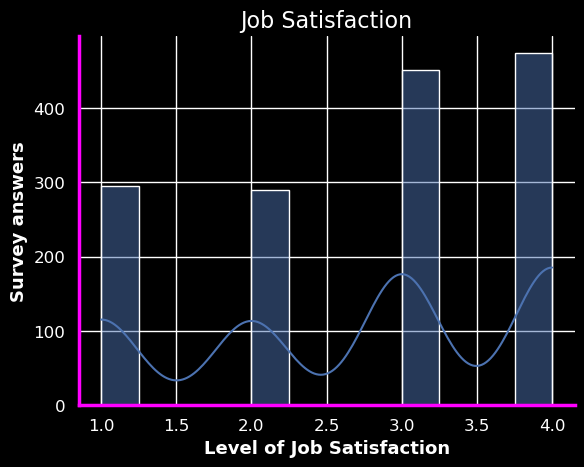

In [24]:
# Hacemos uso de un histograma como método de visualización más efectivo
# para mostrarnos la normalidad en intervalos específicos.

# Establecemos el estilo general de la gráfica.
sns.set_theme(style="darkgrid")

# Creamos la figura y el eje, y establecemos el color de fondo a negro.
fig, ax = plt.subplots()
fig.patch.set_facecolor('black')  # Cambia el color de fondo de la figura a negro.
ax.set_facecolor('black')         # Cambia el color de fondo del área de la gráfica a negro.

# Creamos el hisplot.
sns.histplot(data = df_abtesting,
            x = "job_satisfaction",
            kde = True)

# Ajustamos las etiquetas de los ejes.
ax.set_xlabel('Level of Job Satisfaction', fontsize=13, color='white', weight='bold')
ax.set_ylabel('Survey answers', fontsize=13, color='white', weight='bold')
ax.set_title('Job Satisfaction', fontsize=16, color='white')


# Cambiamos el fondo de los ejes a negro.
ax.set_facecolor('black')  # Fondo del área de la gráfica a negro
ax.spines['top'].set_visible(False)     # Oculta línea superior.
ax.spines['right'].set_visible(False)   # Oculta línea derecha.
ax.spines['left'].set_linewidth(2.5)    # Hace la línea del eje Y más gruesa.
ax.spines['bottom'].set_linewidth(2.5)  # Hace la línea del eje X más gruesa.
ax.spines['left'].set_color('fuchsia')   # Cambia el color de la línea del eje Y.
ax.spines['bottom'].set_color('fuchsia') # Cambia el color de la línea del eje X.


# Cambiamos el color de los números de los ejes.
ax.tick_params(axis='x', colors='white', labelsize=12)
ax.tick_params(axis='y', colors='white', labelsize=12) 

# Mostramos el gráfico.
plt.show()

**<span style="color:#00bf63">Interpretación:</span>**

**Distribución bimodal:** Parece haber **dos picos** en la distribución, uno alrededor de 1.2 y otro más alto alrededor de 3.7. Esto sugiere que hay dos grupos principales de empleados: aquellos que están muy satisfechos con su trabajo y aquellos que están menos satisfechos.

**Poca satisfacción en el medio:** La zona entre los dos picos muestra una frecuencia relativamente baja. Esto indica que hay pocos empleados con niveles de satisfacción intermedios.

**Mayoría de empleados satisfechos:** La mayoría de los empleados parecen estar bastante satisfechos con su trabajo, ya que el pico más alto se encuentra en los niveles más altos de satisfacción.

**Posibles explicaciones:**
- **Dos tipos de roles:** Podría ser que la empresa tenga dos tipos de roles muy diferentes (e.j., directivos y operarios) con niveles de satisfacción muy distintos.

- **Dos culturas organizacionales:** Es posible que existan dos culturas organizacionales diferentes dentro de la empresa, una más satisfactoria que la otra.

- **Cambios recientes:** Quizás se hayan implementado cambios recientes en la empresa que han afectado la satisfacción de los empleados de manera polarizada.

##### **<span style="color:#FFA500">2. Homogeneidad</span>**
- **<span style="color:#FFA500">Test de Levene</span>**

In [12]:
# Realizamos la prueba de Levene.
levene_test = stats.levene(satisfaction_A, satisfaction_B)

# Imprimimos los resultados de la prueba.
print(f"Prueba de Levene: estadístico = {levene_test.statistic}, p-valor = {levene_test.pvalue}")

# Evaluamos la homogeneidad de varianzas.
p_value = levene_test.pvalue
if p_value > 0.05:
    print("Las varianzas son homogéneas entre los dos grupos.")
else:
    print("Las varianzas NO son homogéneas entre los dos grupos.")

Prueba de Levene: estadístico = 0.0953340548949467, p-valor = 0.7575451249370669
Las varianzas son homogéneas entre los dos grupos.


- **<span style="color:#FFA500">Diagrama de caja/Boxplot</span>**

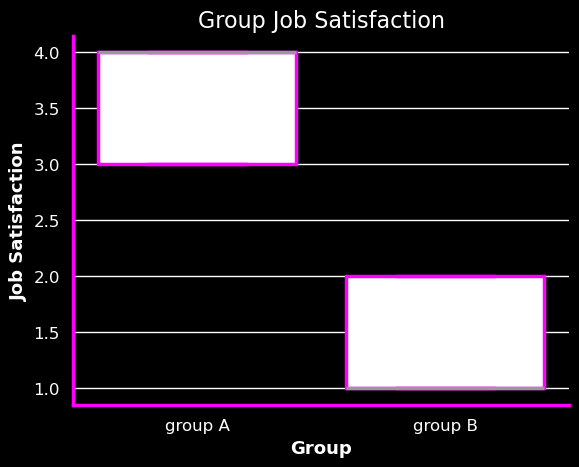

In [32]:
# Hacemos uso de un diagrama de cajas como método de visualización más efectivo
# para mostrarnos la homogeneidad de la varianza.

# Establecemos el estilo general de la gráfica.
sns.set_theme(style="darkgrid")

# Creamos la figura y el eje, y establecemos el color de fondo a negro.
fig, ax = plt.subplots()
fig.patch.set_facecolor('black')  # Cambia el color de fondo de la figura a negro.
ax.set_facecolor('black')         # Cambia el color de fondo del área de la gráfica a negro.

# Creamos el boxplot.
sns.boxplot(data = df_abtesting,
            x = "group",
            y = "job_satisfaction",
            color='white',
            linewidth=2.5,
            boxprops=dict(edgecolor='fuchsia', linewidth=2.5),
            whiskerprops=dict(color='fuchsia', linewidth=2.5),
            capprops=dict(color='fuchsia', linewidth=2.5))

# Ajustamos las etiquetas de los ejes.
ax.set_xlabel('Group', fontsize=13, color='white', weight='bold')
ax.set_ylabel('Job Satisfaction', fontsize=13, color='white', weight='bold')
ax.set_title('Group Job Satisfaction', fontsize=16, color='white')


# Cambiamos el fondo de los ejes a negro.
ax.set_facecolor('black')  # Fondo del área de la gráfica a negro
ax.spines['top'].set_visible(False)     # Oculta línea superior.
ax.spines['right'].set_visible(False)   # Oculta línea derecha.
ax.spines['left'].set_linewidth(2.5)    # Hace la línea del eje Y más gruesa.
ax.spines['bottom'].set_linewidth(2.5)  # Hace la línea del eje X más gruesa.
ax.spines['left'].set_color('fuchsia')   # Cambia el color de la línea del eje Y.
ax.spines['bottom'].set_color('fuchsia') # Cambia el color de la línea del eje X.


# Cambiamos el color de los números de los ejes.
ax.tick_params(axis='x', colors='white', labelsize=12)
ax.tick_params(axis='y', colors='white', labelsize=12) 

# Mostramos el gráfico.
plt.show()

**<span style="color:#00bf63">Interpretación:</span>**

- Las cajas tienen **tamaños similares** y no hay outliers extremos, indicando que las varianzas son homogéneas.

- **La mediana de la satisfacción** en el trabajo parece ser **más alta** en el **grupo A** que en el grupo B.

- El **rango de satisfacción en el grupo A** también parece ser **ligeramente mayor** que en el grupo B.

- **No** se observan **valores atípicos** evidentes en ninguno de los dos grupos.

##### **<span style="color:#FFA500">3. Independencia</span>**
- **<span style="color:#FFA500">Tabla de contingencia</span>**

In [34]:
# Creamos una tabla de contingencia.
contingency_table = pd.crosstab(df_abtesting['attrition'], df_abtesting['group'])

# Realizamos la prueba de chi-cuadrado.
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Imprimimos los resultados.
print("Prueba de chi-cuadrado:")
print(f"Estadístico de chi-cuadrado: {chi2}")
print(f"p-valor: {p}")
print(f"Grados de libertad: {dof}")

# Evaluamos los resultados.
if p < 0.05:
    print("Las variables no son independientes.")
else:
    print("No hay suficiente evidencia para rechazar la hipótesis de independencia.")

Prueba de chi-cuadrado:
Estadístico de chi-cuadrado: 8.432334983446875
p-valor: 0.0036860670797145547
Grados de libertad: 1
Las variables no son independientes.


**<span style="color:#00bf63">Interpretación:</span>**

La prueba de chi-cuadrado ha revelado una relación significativa entre la rotación de empleados y la pertenencia a un grupo.

Dado que el p-valor es menor que el nivel de significancia convencional de 0.05, se rechaza la hipótesis nula y se concluye que existe una asociación estadísticamente significativa entre las variables "attrition" y "group". La probabilidad de que un empleado abandone la empresa (attrition) está relacionada con el grupo al que pertenece

**3. Analizamos los resultados.**

**<span style="color:#01bef4">Normalidad =</span>** los datos **no** siguen una distribucion normal ❌

* La satisfacción en el trabajo no es homogénea en la empresa.
* Existe una segmentación clara en los niveles de satisfacción.

**<span style="color:#01bef4">Homogeneidad =</span>** las varianzas **son homogéneas** ✅

* **Mayor satisfacción en el Grupo A:** Basándose en la mediana, los empleados del grupo A parecen estar, en general, más satisfechos con su trabajo que los del grupo B.

* **Menor variabilidad en el Grupo B:** El rango intercuartílico más pequeño en el grupo B sugiere que la satisfacción de los empleados en este grupo es menos variable, es decir, están más agrupados alrededor de la mediana.

**<span style="color:#01bef4">Independencia =</span>** las variables **no** son independientes ❌

* Las variables "attrition" y "group" no son independientes, lo que sugiere que la pertenencia a un grupo particular influye en la probabilidad de que un empleado abandone la empresa


**<span style="color:#01bef4">CONCLUSIÓN</span>** ➡️ rechazamos, por tanto, la hipótesis nula, ya que sí existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa. Se sospecha que los empleados con niveles de satisfacción más bajos tienen una mayor probabilidad de dejar la empresa.

**4. Calculamos la magnitud de esta relación utilizando estadísticas como la diferencia de medias por ejemplo.**

Elegimos calcular la magnitud de dos formas:
- Utilizando la **correlación de Pearson**, para la que tendremos que cambiar el tipo de "aatrition" de categórica a numérica.

- Utilizando la **regresión logística**, ya que contamos con una **variable dependiente binaria** ("attrition") y una **variable independiente numérica** ("job_satisfaction"), y la regresión logística está diseñada para modelar la probabilidad de que ocurra un evento binario, usándose la variable numérica como predictor.

- **<span style="color:#FFA500">Correlación</span>**

In [35]:
# Estudiamos la correlación entre la satisfacción laboral en la empresa y la probabilidad de abandono.
# Convertimos la columna "attrition" en una variable numérica para poder realizar la prueba (Sí = 1, No = 0)
df_abtesting['attrition_num'] = df_abtesting['attrition'].apply(lambda x: 1 if x == "Yes" else 0)

# Realizamos el test de correlación de Spearman, ya que las variables no siguen una distribución normal.
correlation, p_value = stats.spearmanr(df_abtesting['job_satisfaction'], df_abtesting['attrition_num'])
print(f"Correlación de Spearman: coeficiente = {correlation}, p-valor = {p_value}")

Correlación de Spearman: coeficiente = -0.10312632291758354, p-valor = 5.950977809858895e-05


**<span style="color:#00bf63">Interpretación:</span>**

Existe una **correlación negativa débil** pero estadísticamente significativa ↘️ entre la satisfacción laboral y la probabilidad de abandono de la empresa. Esto sugiere que los empleados más satisfechos con su trabajo tienen menos probabilidades de dejar la empresa.

- **Coeficiente de correlación de Spearman:** Este valor indica la fuerza y dirección de la relación entre las dos variables. En este caso, el coeficiente es -0.182, lo cual indica una correlación negativa débil. Esto significa que a medida que aumenta la satisfacción laboral, tiende a disminuir la probabilidad de que un empleado abandone la empresa.

- **P-valor:** El p-valor es muy pequeño (5.95977889858995e-05), lo que significa que es muy poco probable obtener esta correlación por azar si en realidad no existiera una relación entre las dos variables. Por lo tanto, podemos rechazar la hipótesis nula de que no hay correlación y concluir que existe una correlación estadísticamente significativa.

- **Correlación no implica causalidad:** Aunque existe una relación negativa, esto no significa necesariamente que la baja satisfacción laboral cause que los empleados se vayan. Podría haber otras variables involucradas o una relación más compleja.

- **Debilidad de la correlación:** El coeficiente de correlación es relativamente bajo (-0.182), lo que indica que la relación entre las dos variables no es muy fuerte.

- **<span style="color:#FFA500">Regresión logística</span>**

In [39]:
# Calculamos el coeficiente para la variable "job_satisfaction" para observar 
# cómo cambia la probabilidad logarítmica de rotación por cada unidad de aumento en la satisfacción laboral.

# Convertimos la columna "attrition" en una variable numérica para poder realizar la prueba (Sí = 1, No = 0)
df_abtesting['attrition_num'] = df_abtesting['attrition'].apply(lambda x: 1 if x == "Yes" else 0)
model = logit('attrition_num ~ job_satisfaction', data = df_abtesting).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.433709
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          attrition_num   No. Observations:                 1510
Model:                          Logit   Df Residuals:                     1508
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Oct 2024   Pseudo R-squ.:                 0.01207
Time:                        12:11:14   Log-Likelihood:                -654.90
converged:                       True   LL-Null:                       -662.91
Covariance Type:            nonrobust   LLR p-value:                 6.305e-05
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.9981      0.174     -5.731      0.000      -1.339      -0.657
job_satisfa

**<span style="color:#00bf63">Interpretación:</span>**
Existe una **correlación negativa débil** que confirma que existe una relación negativa entre la satisfacción laboral y la probabilidad de rotación, es decir, que a mayor satisfacción laboral, menor probabilidad de que un empleado abandone la empresa.

Aunque la relación es estadísticamente significativa, la magnitud del coeficiente no es muy grande. Esto sugiere que la satisfacción laboral es un factor importante a considerar, pero puede no ser el único factor que influye en la rotación de empleados, es decir, la correlación no implica causalidad. Otros factores como el salario, las oportunidades de crecimiento o el clima laboral también pueden jugar un papel importante.